<img src="./pic/sharif-main-logo.png" alt="SUT logo" width=345 height=345 align=left class="saturate">


<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 - Unsupervised Learning<br>
<font color=696880 size=4>
    Assignment Supervisor: Niki Sepasian <br>
<font color=696880 size=5>
    Asemaneh Nafe


In [107]:
student_number = 401110347
full_name = 'Parsa Ghezelbash'
assert student_number and full_name is not None, 'please input your information'

In [108]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

<font color=red size=3>
notice that you can not use sklearn.decomposition and sklearn.cluster libary in this home work! you should implement pca and kmeans from scratch.

## Overview
In this assignment, you will perform PCA and K-Means clustering on credit card customer data. dataset contains information about customer’s use of credit cards. The goal is to reduce the dataset’s dimensionality using PCA and then apply clustering to segment customers. You will compare the clustering performance both before and after PCA. Additionally, you'll be asked to explain the theory and decisions behind each step.

## Data Preprocessing (15 points)
Read the dataset.CSV file and display a few samples.

In [109]:
df = pd.read_csv('dataset.csv')
print(df[['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES']].head())
print(df[['INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY']].head())
print(df[['ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']].head())
print(df[['CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT']].head())
print(df[['PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']].head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  ONEOFF_PURCHASES
0  C10001    40.900749           0.818182              0.00
1  C10002  3202.467416           0.909091              0.00
2  C10003  2495.148862           1.000000            773.17
3  C10004  1666.670542           0.636364           1499.00
4  C10005   817.714335           1.000000             16.00
   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY
0                    95.4      0.000000             0.166667
1                     0.0   6442.945483             0.000000
2                     0.0      0.000000             1.000000
3                     0.0    205.788017             0.083333
4                     0.0      0.000000             0.083333
   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY
0                    0.000000                          0.083333
1                    0.000000                          0.000000
2                    1.000000                          0.000000
3                 

Display dataset information.

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Which column do you think might be the most irrelevant for PCA and clustering?
<br>
Answer: CUST_ID column should be removed because the model's prediction should be independent of IDs.

In [111]:
# Exclude irrelevant feature
df = df.drop(columns=['CUST_ID'])
print(df[['BALANCE', 'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES']].head())
print(df[['INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY']].head())
print(df[['ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']].head())
print(df[['CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT']].head())
print(df[['PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']].head())

       BALANCE  BALANCE_FREQUENCY  ONEOFF_PURCHASES
0    40.900749           0.818182              0.00
1  3202.467416           0.909091              0.00
2  2495.148862           1.000000            773.17
3  1666.670542           0.636364           1499.00
4   817.714335           1.000000             16.00
   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY
0                    95.4      0.000000             0.166667
1                     0.0   6442.945483             0.000000
2                     0.0      0.000000             1.000000
3                     0.0    205.788017             0.083333
4                     0.0      0.000000             0.083333
   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY
0                    0.000000                          0.083333
1                    0.000000                          0.000000
2                    1.000000                          0.000000
3                    0.083333                          0.000000
4 

how do you handle missing data, and why did you choose this method?
<br>
Answer: I fill missing datas with the mean of non missing datas of the same column. This way the mean of that column won't change.


In [112]:
#Fill missing data
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())
df.isnull().any().any()

False

plot the correlation matrix and identify redundant features.remove them from the dataframe.

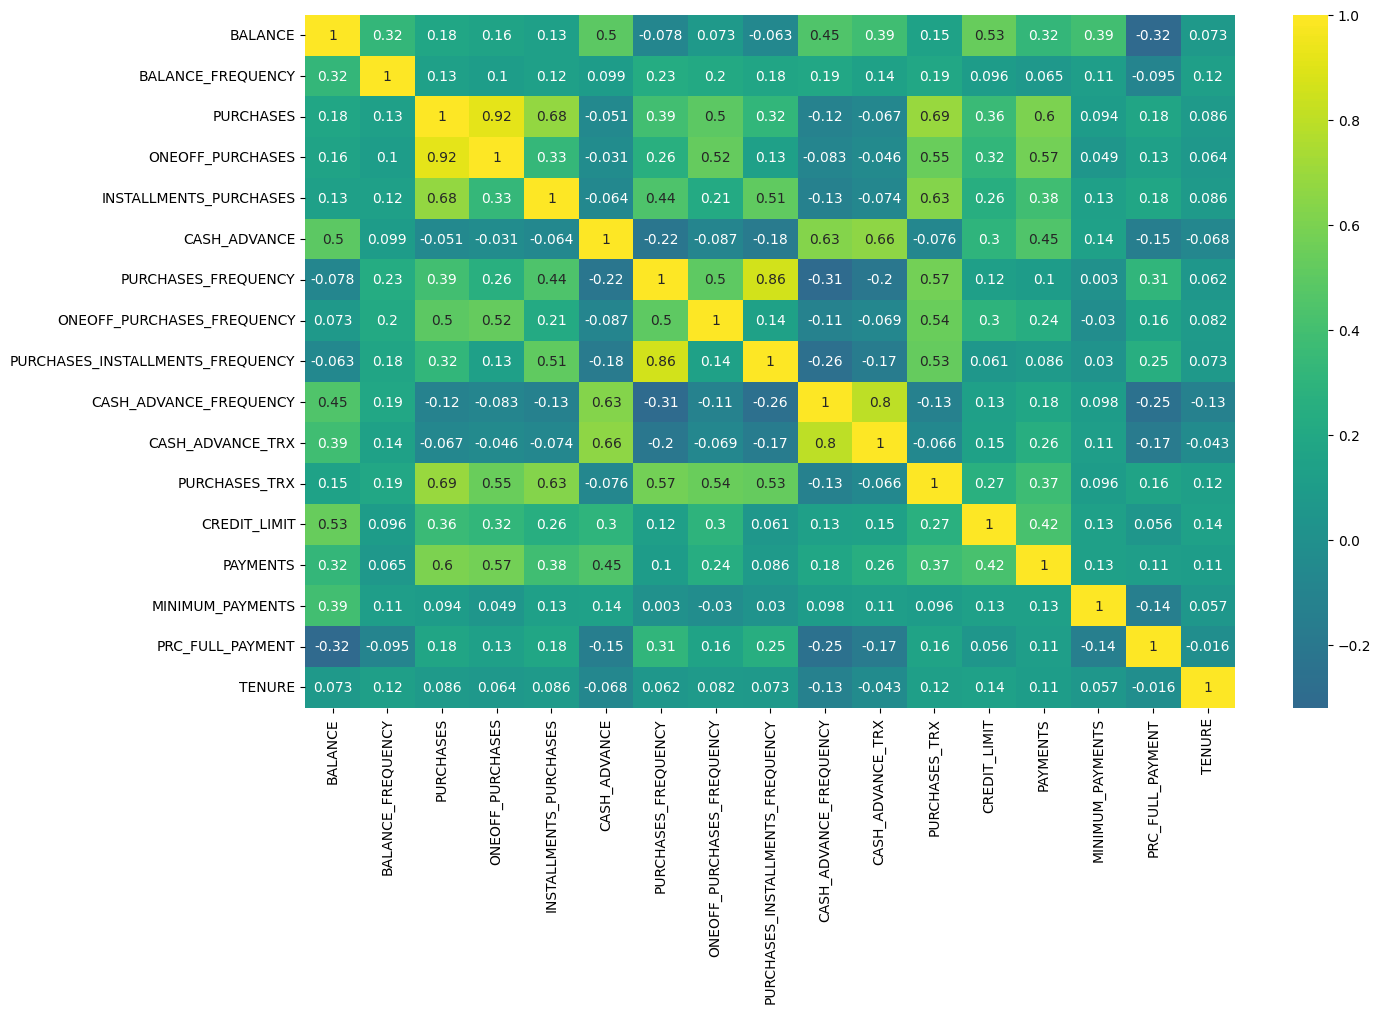

In [113]:
# Plot the correlation matrix
plt.figure(figsize=(15, 9))
sns.heatmap(df.corr(), annot=True, center=0, cmap='viridis')
plt.show()


In [114]:
# Identify and remove redundant features. use 0.8 threshold.
corr = df.corr()
rows, cols = np.where(abs(corr) > 0.8)

pairs = zip(df.columns[rows], df.columns[cols])
redundant_paris = list(set([tuple(sorted(pair)) for pair in pairs]))
feature_pairs = list(zip(df.columns, df.columns))
redundant_paris = set(redundant_paris) - set(feature_pairs)

for pair in redundant_paris:
    print(f'redundant pair: {pair}')
    df = df.drop(columns=[pair[0]])
# df = df.drop(columns=['PURCHASES_INSTALLMENTS_FREQUENCY', 'ONEOFF_PURCHASES'])
df

redundant pair: ('ONEOFF_PURCHASES', 'PURCHASES')
redundant pair: ('PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY')


,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,95.40,0.000000,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,6442.945483,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,0.00,205.788017,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,291.12,0.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,300.00,0.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,864.206542,0.000000,6
8947,23.398673,0.833333,144.40,144.40,0.000000,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,36.558778,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


## Standardize the Data (5 points)
Standardize the dataset using z-score normalization

In [115]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.349079,-0.466786,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960433,-0.528979,-3.109675e-01,-0.525551,0.360680
1,0.786961,0.134325,-0.469552,-0.454576,2.605605,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688639,0.818642,8.931021e-02,0.234227,0.360680
2,0.447135,0.518084,-0.107668,-0.454576,-0.466786,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826062,-0.383805,-1.016632e-01,-0.525551,0.360680
3,0.049099,-1.016953,0.232058,-0.454576,-0.368653,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826062,-0.598688,4.878305e-17,-0.525551,0.360680
4,-0.358775,0.518084,-0.462063,-0.454576,-0.466786,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905464,-0.364368,-2.657913e-01,-0.525551,0.360680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.737950,0.518084,-0.333293,-0.132643,-0.466786,-0.678661,1.179833,-0.675349,-0.476070,-0.350408,-0.960433,-0.486217,-3.498541e-01,1.183951,-4.122768
8946,-0.742423,0.518084,-0.329136,-0.122823,-0.466786,-0.678661,1.179833,-0.675349,-0.476070,-0.350408,-0.960433,-0.503396,4.878305e-17,-0.525551,-4.122768
8947,-0.740398,-0.185477,-0.401965,-0.294893,-0.466786,-0.678661,0.760469,-0.675349,-0.476070,-0.390639,-0.960433,-0.570615,-3.354655e-01,0.329200,-4.122768
8948,-0.745174,-0.185477,-0.469552,-0.454576,-0.449352,-0.678661,-0.916995,0.157527,-0.182998,-0.591796,-1.097856,-0.580536,-3.469065e-01,0.329200,-4.122768


Why is it important to standardize the data before applying PCA?
<br>
Answer: PCA wants to find directions in which the variance of data is maximized.

If a column's range is higher than other then it will be dominant and pricipal component will have more tendency to this column.

What is differnce between Normalizer and StandardScaler classes. which is better for PCA?
<br>
Answer: StandardScaler scales each column individually causing the column have same mean and variance and make each feature contribute equally. This is better for PCA.

Normalizer normalizes each row so that it's norm is 1. This could cause change the relation between features and is not appropriate for PCA.

## Principal Component Analysis (PCA) (35 points)
Implement PCA from scratch.

In [116]:
import numpy as np
import scipy as sp

class CustomPCA:
    def __init__(self, n_components=None):
        """
        Initialize the PCA class with the number of components to keep.
        n_components: Number of principal components to keep. If None, all components are kept.
        """
        self.n_components = n_components
        self.components = None  # To store the principal components (eigenvectors)
        self.mean = None        # To store the mean of the data (used for centering the data)
        self.explained_variance_ratio = None  # To store the explained variance ratio of the components

    def fit(self, X):
        """
        Fit the PCA model on the dataset X by calculating the eigenvalues and eigenvectors of the covariance matrix.
        X: Input data (n_samples, n_features)
        """
        self.mean = np.mean(X, axis=0)
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        X_hat = X - self.mean
        S = (X_hat.T @ X_hat) / X.shape[0]
        eigenvalues, eigenvectors = sp.linalg.eigh(S)

        indices = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, indices]
        self.eigenvalues = eigenvalues[indices]

        self.explained_variance_ratio = self.eigenvalues / np.sum(self.eigenvalues)


    def transform(self, X):
        """
        Transform the input data X into the new space using the principal components.
        X: Input data (n_samples, n_features)
        """
        # Return the transformed data
        A = self.components[:, :min(self.n_components, self.n_features)]
        return X @ A


    def get_explained_variance_ratio(self):
        """
        Return the explained variance ratio of each principal component.
        """
        return np.sum(self.explained_variance_ratio[:min(self.n_components, self.n_features)])

    def get_components(self):
        """
        Return the principal components (eigenvectors).
        """
        return self.components

### Visualizing the Cumulative Variance

Plot the cumulative explained variance to visualize the selection of components.  How many components are needed to explain 75% of the variance?
<br>
answer: We need at least 5 components for cumulative explained variance to be more than 75%.

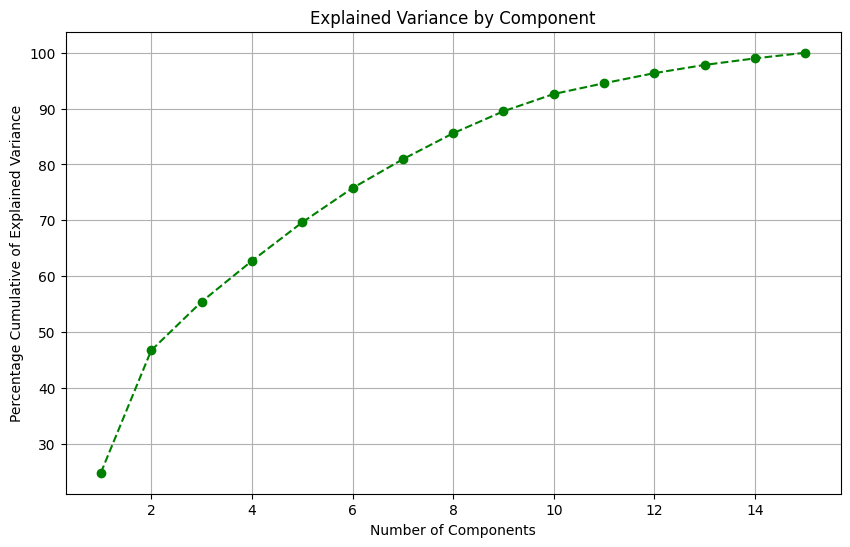

minimum number of components we have to keep for cumulative explained variance to be more than 75%: 5
[0.24842034 0.46726784 0.55429759 0.6273536  0.69636684 0.75775111
 0.80941666 0.85588847 0.89523924 0.92618492 0.94541954 0.96351309
 0.9782155  0.98990467 1.        ]


In [117]:
# todo
n_components_candidates = range(1, df.shape[1]+1)

pca = CustomPCA()
cumulative_explained_variance_ratios = []
pca.fit(df)

for n_components in n_components_candidates:
    pca.n_components = n_components
    cumulative_explained_variance_ratios.append(pca.get_explained_variance_ratio())
cumulative_explained_variance_ratios = np.array(cumulative_explained_variance_ratios)

plt.figure(figsize=(10, 6))
plt.plot(n_components_candidates, cumulative_explained_variance_ratios * 100, c='green', marker='o', linestyle='--')
plt.grid(visible=True)
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Percentage Cumulative of Explained Variance')
plt.show()

min_components = np.argmax(cumulative_explained_variance_ratios > 0.75)
print(f'minimum number of components we have to keep for cumulative explained variance to be more than 75%: {min_components}')
print(cumulative_explained_variance_ratios)

Build a new DataFrame with the first slected components. save it to a new CSV file named 'pca_output.csv'

In [118]:
#Build a new DataFrame with the first slected components
pca.n_components = min_components
new_df = pca.transform(df)
new_df.columns = [f'PC{i+1}' for i in range(min_components)]
new_df.to_csv('pca_output.csv')
new_df

,PC1,PC2,PC3,PC4,PC5
0,1.776474,-0.629426,0.383692,0.290424,-0.060759
1,-0.165519,2.440563,-0.612770,0.908953,-0.301224
2,-0.454003,-0.381331,0.854655,1.622491,1.933242
3,0.832827,0.073005,0.189745,1.495068,-0.416764
4,1.507572,-0.352143,0.756413,0.288983,0.443291
...,...,...,...,...,...
8945,1.328736,-1.304448,-1.489970,-2.863552,-0.776681
8946,1.413533,-0.855365,-0.562849,-2.803935,-0.970140
8947,1.744846,-1.021559,-1.397754,-2.356213,-1.026140
8948,2.274693,-0.023146,-1.719610,-1.833629,-0.643826


We expect these new features to be orthogonal to each other. Check this and show the correlation between the features.

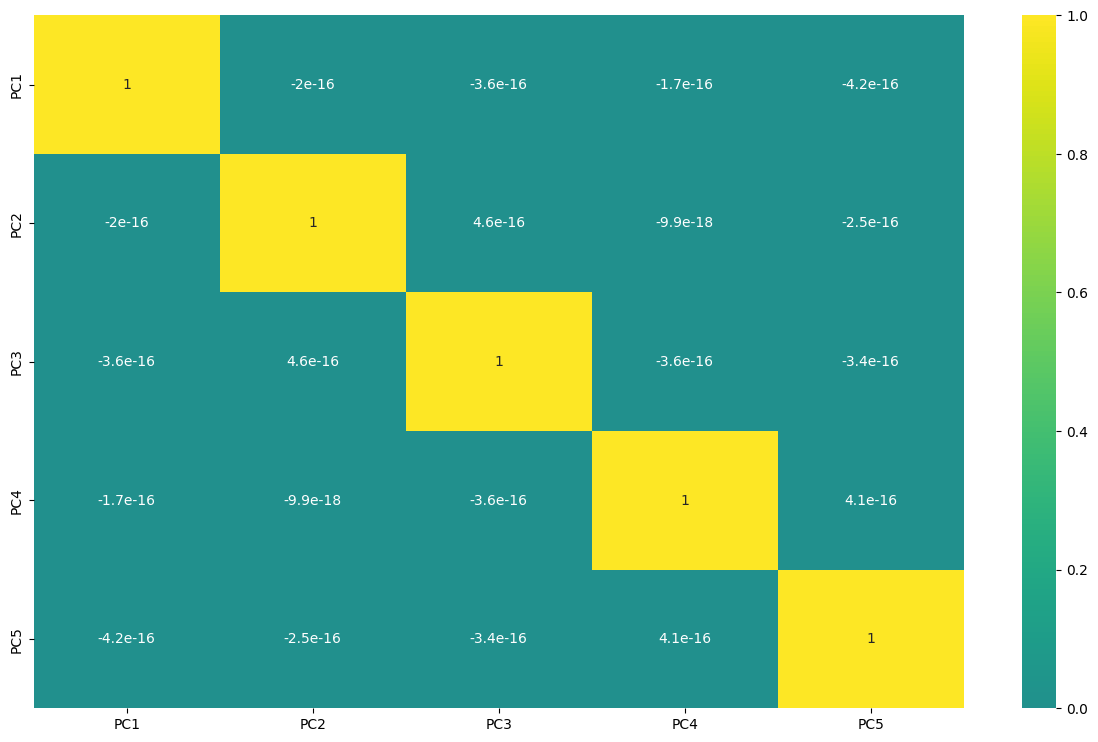

In [119]:
# Plot the correlation matrix
plt.figure(figsize=(15, 9))
sns.heatmap(new_df.corr(), annot=True, center=0, cmap='viridis')
plt.show()

## KMeans (45 points)
Implement kmeans from scratch.

In [120]:
import numpy as np

class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        """
        Initialize the KMeans class with the number of clusters and maximum iterations.
        n_clusters: Number of clusters to form.
        max_iter: Maximum number of iterations for convergence.
        random_state: Seed for reproducibility.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None  # To store the centroids of clusters
        self.inertia_ = None   # To store the inertia (within-cluster sum of squares)
        self.labels_ = None    # To store the label assigned to each data point (cluster assignment)

    def fit(self, X):
        """
        Fit the KMeans model on the dataset X.
        X: Input data (n_samples, n_features)
        """
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        indices = np.random.choice(self.n_samples, size=self.n_clusters, replace=False)
        self.centroids = X[indices]
        clusters = {}

        for _ in range(self.max_iter):
            dists = np.sum((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :])**2, axis=2)
            self.labels_ = np.argmin(dists, axis=1)
            for cluster in range(self.n_clusters):
                clusters[cluster] = X[self.labels_==cluster]
                self.centroids[cluster] = np.mean(clusters[cluster], axis=0)
        self._calculate_inertia(X)
        return self

    def _calculate_inertia(self, X):
        """
        Calculate the within-cluster sum of squared distances (inertia).
        X: Input data (n_samples, n_features)
        Returns: inertia (float)
        """
        # Step 1: For each cluster, compute the squared distances of points from their corresponding centroid
        # Step 2: Sum all squared distances to compute inertia
        self.inertia_ = 0
        for cluster in range(self.n_clusters):
            self.inertia_ += np.sum((X[self.labels_==cluster] - self.centroids[cluster])**2)
        return self.inertia_

### Elbow Method
Apply the elbow method to determine the optimal number of clusters for K-Means. what is the best number of clusters?

In [121]:
# Initialize an empty list to store the WCSS values for each number of clusters
WCSS = []

# Apply KMeans for a range of cluster values (from 1 to 30)
for i in range(1, 30):
    # Initialize the CustomKMeans with `i` clusters and a random state of 42
    kmeans_pca = CustomKMeans(n_clusters=i, random_state=42)
    
    # Fit the model to the PCA-transformed data
    kmeans_pca.fit(new_df.values)
    

    # Append the calculated inertia (WCSS) to the WCSS list
    WCSS.append(kmeans_pca.inertia_)

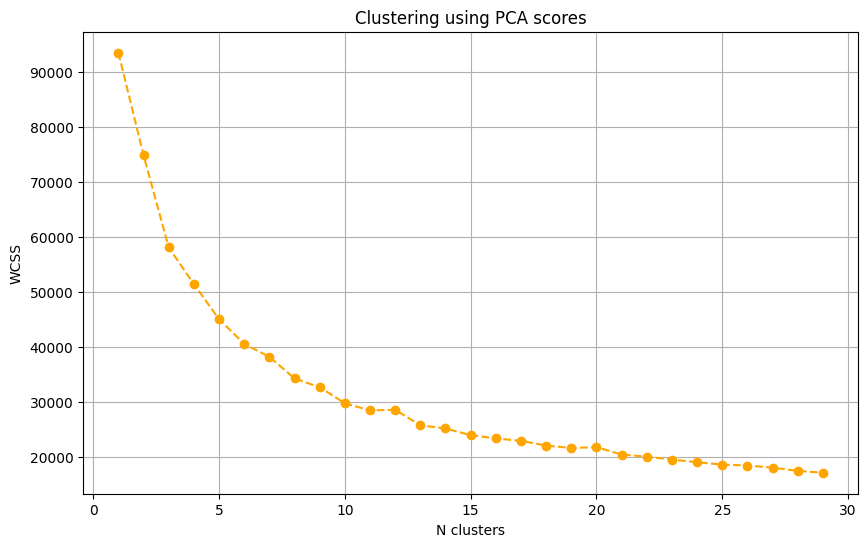

In [122]:
# Plot the Elbow curve using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), WCSS, c='orange', marker='o', linestyle='--')
plt.grid(True)
plt.title('Clustering using PCA scores')
plt.xlabel('N clusters')
plt.ylabel('WCSS')
plt.show()

Apply the optimal KMeans clustering on the PCA-transformed data, and assign cluster labels to each observation. Add a new column named segment to the df_pca DataFrame to store these labels.

In [123]:
# Apply KMeans on PCA-reduced data with the optimal number of clusters based on the elbow method
best_n_clusters = 9
kmeans_pca = CustomKMeans(n_clusters=best_n_clusters)
kmeans_pca.fit(new_df.values)
kmeans_pca.labels_

array([2, 3, 2, ..., 4, 4, 4])

In [124]:
# Add a new column 'segment' to pca data frame and assign the cluster labels to each observation
new_df['segment'] = kmeans_pca.labels_
new_df

,PC1,PC2,PC3,PC4,PC5,segment
0,1.776474,-0.629426,0.383692,0.290424,-0.060759,2
1,-0.165519,2.440563,-0.612770,0.908953,-0.301224,3
2,-0.454003,-0.381331,0.854655,1.622491,1.933242,2
3,0.832827,0.073005,0.189745,1.495068,-0.416764,2
4,1.507572,-0.352143,0.756413,0.288983,0.443291,2
...,...,...,...,...,...,...
8945,1.328736,-1.304448,-1.489970,-2.863552,-0.776681,4
8946,1.413533,-0.855365,-0.562849,-2.803935,-0.970140,4
8947,1.744846,-1.021559,-1.397754,-2.356213,-1.026140,4
8948,2.274693,-0.023146,-1.719610,-1.833629,-0.643826,4


 visualize the clustering by plotting the pairwise relationships of the PCA-reduced features, color-coded by the cluster assignments.

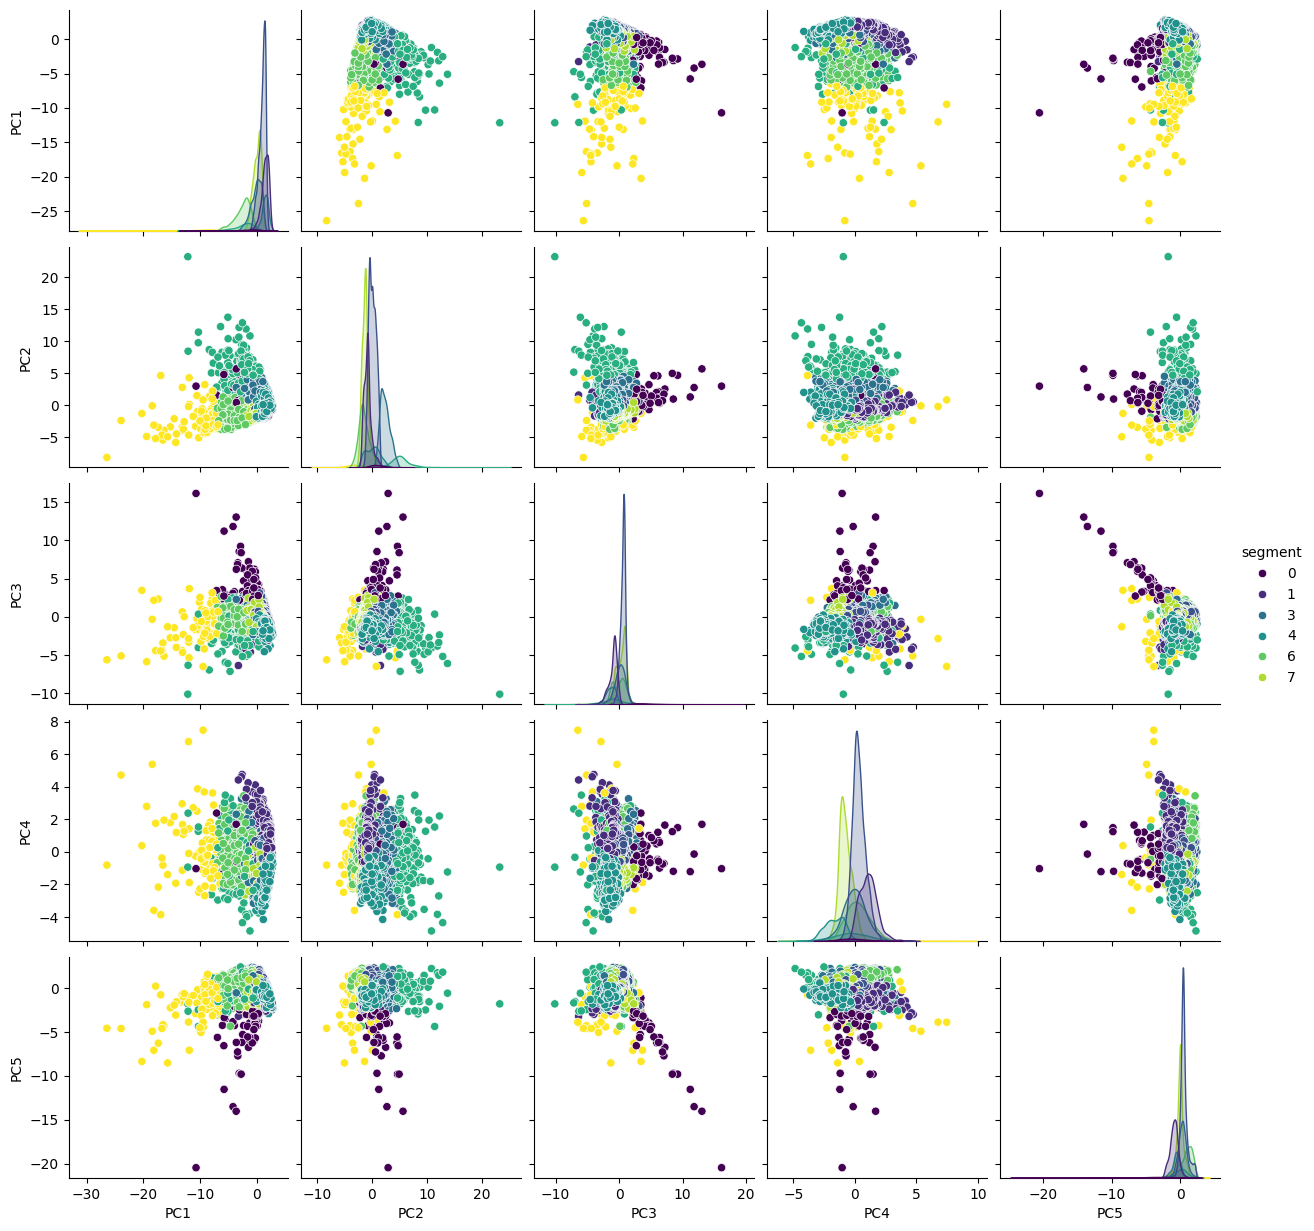

In [125]:
sns.pairplot(new_df, hue="segment", palette='viridis')
plt.show()

So, when we employ PCA prior to using K-means we can visually separate almost the entire data set. That was one of the biggest goals of PCA - to reduce the number of variables by combining them into bigger, more meaningful features.

### Hierarchical Clustering
Perform hierarchical clustering on the reduced dataset after PCA. Use complete linkage method.


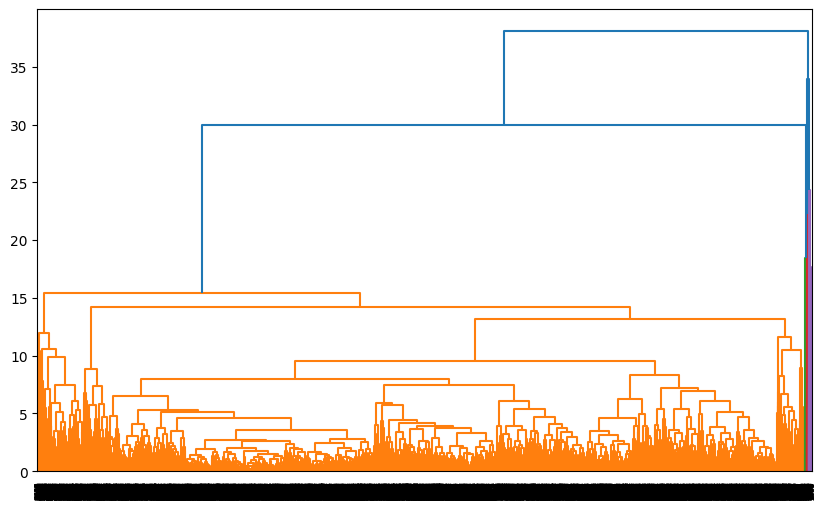

In [126]:
# Perform Hierarchical Clustering on the pca dataset
linkage_data = linkage(new_df.drop(columns=['segment']), method='complete')
# Visualize the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_data)
plt.show()


"Use scipy.cluster.hierarchy.fcluster to assign clusters from the dendrogram with a specified number of 5 clusters. Then visualize the results using pairplots.

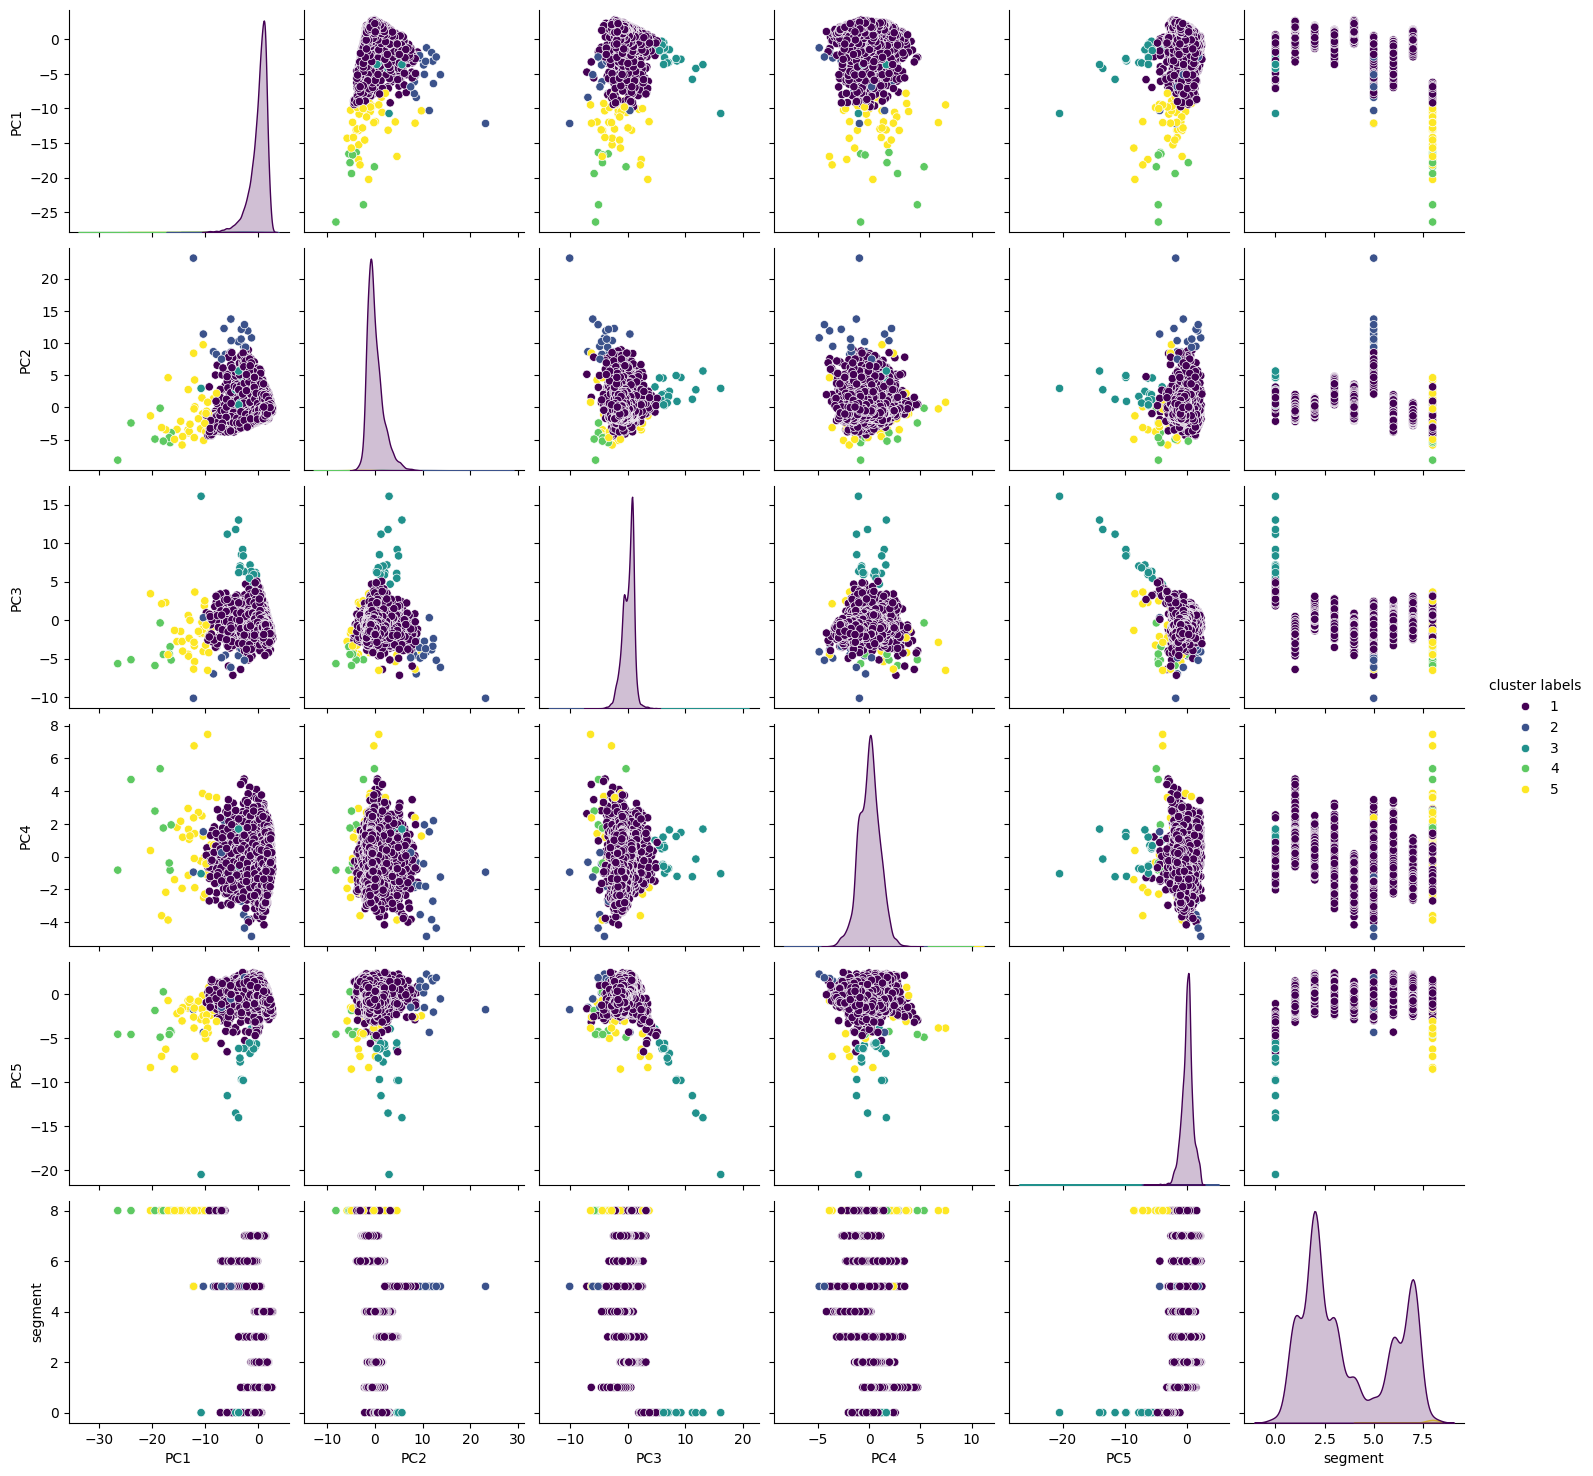

In [127]:
# Choose threshold and assign clusters
fc = fcluster(linkage_data, t=5, criterion='maxclust')
# Assign cluster labels to PCA DataFrame
new_df['cluster labels'] = fc
# Visualize using PCA components
sns.pairplot(new_df, hue="cluster labels", palette='viridis')
plt.show()